In [1]:
import time
import sys
import os
from collections import OrderedDict
from importlib import reload
from pprint import pprint

import h5py
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
import qcodes
qc = qcodes

In [3]:
from stationq.mplplots.init_nb_plotting import *
from stationq.mplplots import plots as mplplots
from stationq.mplplots import tools as mpltools

In [4]:
from quantum_capacitance import rf; reload(rf)
from quantum_capacitance.rf import AlazarMeasurementExt, AWGMeasurement, AWG2DRamp

# Basic configuration

In [5]:
%run init.py

2018-01-18 14:31:33,575 : measurement : INFO : Logger set up!


Initialized IVVI-rack in 0.13s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110525, firmware:3.1.19.15-3.50.124.67) in 0.01s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110524, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: TEKTRONIX AWG5014C (serial:B051388, firmware:SCPI:99.0 FW:4.6.0.7) in 0.05s
Connected to: Rigol Technologies DG4062 (serial:DG4E163251554, firmware:00.01.09) in 0.05s


C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:514: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:526: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


In [6]:
from stationq.data.data_storage import Data, GridData
Data.export_spyview = True
GridData.export_spyview = True

# Definitions

# Experiments

## Test: alazar time trace

In [ ]:
# %run -i snippets/alazar_timetrace.py

## RF reflectometry

In [107]:
t1, t2, t3 = int(station.ivvi.dac4()), int(station.ivvi.dac5()), int(station.ivvi.dac6())
t1, t2, t3

(-1014, -597, -879)

In [82]:
class AWGGateSweep2D(AWG2DRamp, AlazarMeasurementExt):
    
    data_cls = GridData
    n_avgs = 1
    
    def setup(self):
        super().setup()
        self.station.LO.frequency(self.station.RF.frequency() + self.IF())
        
        self.alazar_axes = OrderedDict({
            'Gate 1 (V)' : np.linspace(self.ramp_min[0], self.ramp_max[0], self.ramp_pts[0]),
#             'Line Repetition' : np.arange(self.line_reps),
            'Gate 2 (V)' : np.linspace(self.ramp_min[1], self.ramp_max[1], self.ramp_pts[1]),
            'Averages' : np.arange(self.n_avgs),
        })
    
    def measure(self):
        data = self.acquire().reshape(self.n_avgs, self.ramp_pts[1], self.ramp_pts[0], 2)
        magA = np.abs(data[...,0])
        magB = np.abs(data[...,1])
        phase = np.angle(data[...,0] * data[...,1].conj(), deg=True)
        
        ret = OrderedDict({
            'magA' : {'value' : magA},
            'magB' : {'value' : magB},
            'phase' : {'value' : phase},
        })
        
        axgrid = np.meshgrid(*[v for k, v in self.alazar_axes.items()], indexing='ij')
        for i, k in enumerate(self.alazar_axes):
            ret[k] = {'value' : axgrid[i].T, 'independent_parameter' : True}
            
        self.data.add(ret)
    
    def plot(self):
        z1, [(xname, x), (yname, y), (_, _) ] = m.data["magB"]
        z2, [(xname, x), (yname, y), (_, _) ] = m.data["phase"]

        fig, gs = mpltools.get_fig([2., 0.1,  0.5, 2., 0.1], [2.], dw=0.1, make_axes=False)

        ax1 = fig.add_subplot(gs[0,0])
        cax1 = fig.add_subplot(gs[0,1])
        im1 = mplplots.ppcolormesh(ax1, x, y, z1[:,:,:].mean(axis=-1).T)
        cb1 = fig.colorbar(im1, cax=cax1)
        mpltools.format_right_cax(cax1)

        ax1.set_xlabel(xname)
        ax1.set_ylabel(yname)
        cb1.set_label('magnitude (a.u.)')

        ax2 = fig.add_subplot(gs[0,3])
        cax2 = fig.add_subplot(gs[0,4])
        im2 = mplplots.ppcolormesh(ax2, x, y, z2[:,:,:].mean(axis=-1).T)
        cb2 = fig.colorbar(im2, cax=cax2)
        mpltools.format_right_cax(cax2)

        ax2.set_xlabel(xname)
        ax2.set_yticklabels([])
        cb2.set_label('phase (deg)')
        
        fig.suptitle(m.datafilepath, size='small')
        fig.savefig(m.data_prefix + ".png", dpi=300)

In [9]:
namespace.ats_settings['sample_rate'] = int(1e8)
namespace.ats_settings['trigger_source1'] = 'EXTERNAL'
namespace.ats_settings['timeout_ticks'] = 10 * int(1e6)

namespace.awg_settings['sampling_rate'] = int(1e7)
namespace.awg_settings['channel_1']['analog_amplitude'] = 4.0
namespace.awg_settings['channel_2']['analog_amplitude'] = 0.2


station.RF.power(-25)
station.LO.power(22)

2018-01-18 18:17:11,733 : measurement : INFO : Ready to measure, file location: d:\data\2018-01\2018-01-18\2018-01-18_AWGGateSweep2D-#0154_t1=-1290_t2=-597_t3=-885_RF=538MHz...


rec time: 98.560 us
msmt size: 252.3 MB
data rate: 31.5 MB/s
Instrument alazar_ctl already exists.


2018-01-18 18:17:31,621 : measurement : INFO : Measurement finished, cleaning up...
2018-01-18 18:17:31,837 : measurement : INFO : All done!


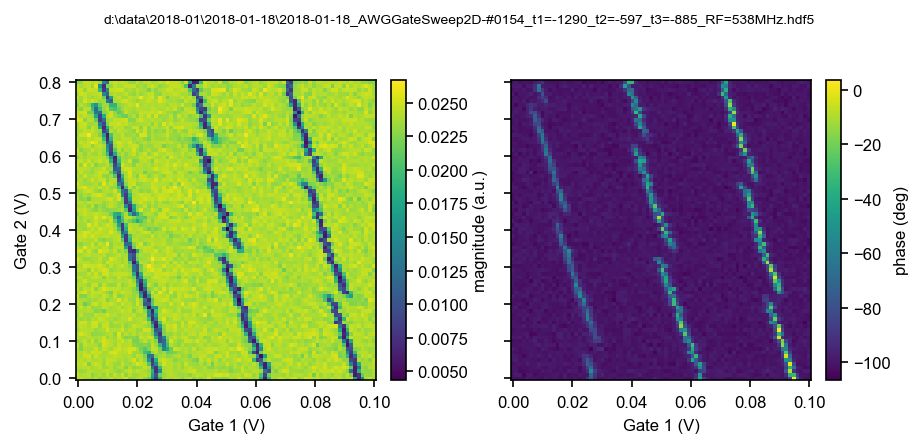

In [173]:
frq = 538.2e6

t1 = -1290
t2 = -597
t3 = -885

trigger_frq = 10

station.RF.frequency(frq)
station.ivvi.dac4(t1)
station.ivvi.dac5(t2)
station.ivvi.dac6(t3)
station.fg.ch1_output_enabled(False)
station.fg.ch1_frequency(trigger_frq)

info = f't1={int(t1)}_t2={int(t2)}_t3={int(t3)}_RF={frq*1e-6:.0f}MHz'

m = AWGGateSweep2D(station, namespace, info_string=info)
m.trigger_func = station.fg.ch1_output_enabled

m.trigger_chan = 'ch2_m1'
m.ramp_chan = (2, 1)
m.ramp_pts = (80, 80)
m.ramp_min = (0, 0)
m.ramp_max = (0.1, 0.8)
m.ramp_elt_len = 0.1e-3
m.ramp_down_len = 2e-3
m.n_avgs = 1

m.IF(8e6)
m.ats_samples_per_record = int((m.ramp_elt_len * namespace.ats_settings['sample_rate'] // 128 - 1) * 128)
m.ats_records_per_buffer = int(m.ramp_pts[0])
m.ats_buffers_per_acquisition = int(m.ramp_pts[1] * m.n_avgs)
m.ats_allocated_buffers = 10

spr = m.ats_samples_per_record
rec_time = m.ats_samples_per_record / float(namespace.ats_settings['sample_rate'])
alloc_size = 4 * spr * m.ats_records_per_buffer * m.ats_buffers_per_acquisition * 1e-6
drate = 4 * spr * m.ats_records_per_buffer * 1e-6 * trigger_frq

print(f"rec time: {rec_time*1e6:.3f} us")
print(f"msmt size: {alloc_size:.1f} MB")
print(f"data rate: {drate:.1f} MB/s")

m.do_setup_awg = True
m.run()
m.plot()

2018-01-18 18:18:13,829 : measurement : INFO : Ready to measure, file location: d:\data\2018-01\2018-01-18\2018-01-18_AWGGateSweep2D-#0155_t1=-1290_t2=-597_t3=-885_RF=1398MHz...


rec time: 98.560 us
msmt size: 2523.1 MB
data rate: 31.5 MB/s
Instrument alazar_ctl already exists.


2018-01-18 18:19:47,632 : measurement : INFO : Measurement finished, cleaning up...
2018-01-18 18:19:47,895 : measurement : INFO : All done!


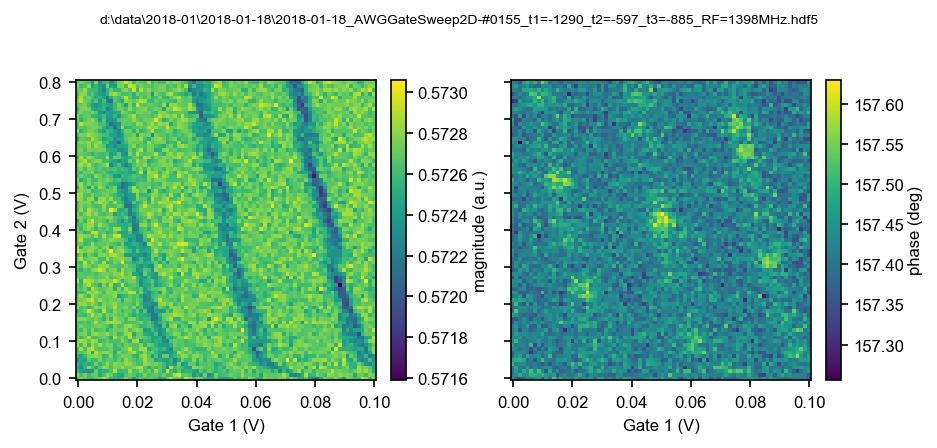

In [174]:
frq = 1.398e9
station.RF.frequency(frq)

station.fg.ch1_output_enabled(False)
station.fg.ch1_frequency(trigger_frq)

info = f't1={int(t1)}_t2={int(t2)}_t3={int(t3)}_RF={frq*1e-6:.0f}MHz'

m = AWGGateSweep2D(station, namespace, info_string=info)
m.trigger_func = station.fg.ch1_output_enabled

m.trigger_chan = 'ch2_m1'
m.ramp_chan = (2, 1)
m.ramp_pts = (80, 80)
m.ramp_min = (0, 0)
m.ramp_max = (0.1, 0.8)
m.ramp_elt_len = 0.1e-3
m.ramp_down_len = 2e-3
m.n_avgs = 10

m.IF(8e6)
m.ats_samples_per_record = int((m.ramp_elt_len * namespace.ats_settings['sample_rate'] // 128 - 1) * 128)
m.ats_records_per_buffer = int(m.ramp_pts[0])
m.ats_buffers_per_acquisition = int(m.ramp_pts[1] * m.n_avgs)
m.ats_allocated_buffers = 10

spr = m.ats_samples_per_record
rec_time = m.ats_samples_per_record / float(namespace.ats_settings['sample_rate'])
alloc_size = 4 * spr * m.ats_records_per_buffer * m.ats_buffers_per_acquisition * 1e-6
drate = 4 * spr * m.ats_records_per_buffer * 1e-6 * trigger_frq

print(f"rec time: {rec_time*1e6:.3f} us")
print(f"msmt size: {alloc_size:.1f} MB")
print(f"data rate: {drate:.1f} MB/s")

m.do_setup_awg = True
m.run()
m.plot()

In [ ]:
# class MultiFrqGateSweep(AWGGateSweep2D):
    
#     RF_frqs = [538.2e6, 1.398e9]
#     RF_pwrs = [[-60.,], [-35.,]]
    
#     def measure(self):
        
#         ret = OrderedDict({})
#         axgrid = np.meshgrid(*[v for k, v in self.alazar_axes.items()], indexing='ij')
#         for i, k in enumerate(self.alazar_axes):
#             ret[k] = {'value' : axgrid[i].T, 'independent_parameter' : True}
        
#         for frq, pwr_lst in zip(self.RF_frqs, self.RF_pwrs):
#             for pwr in pwr_lst:
#                 suffix = f"{frq*1e-9:.4f}GHz_{pwr}dBm"
                
#                 self.station.RF.frequency(frq)
#                 self.station.RF.power(pwr)
#                 self.station.LO.frequency(self.station.RF.frequency() + self.IF())
#                 time.sleep(0.5)
                
#                 A, B = self.acquire()
#                 A2 = A[:].reshape(self.ramp_pts[1], self.line_reps, self.ramp_pts[0])
#                 B2 = B[:].reshape(self.ramp_pts[1], self.line_reps, self.ramp_pts[0])

#                 amp = np.abs(B2)
#                 phase = np.angle(A2*B2.conj(), deg=True)
#                 ret[f'amp_{suffix}'] = {'value' : amp}
#                 ret[f'phase_{suffix}'] = {'value' : phase}

#         self.data.add(ret)

# t1 = -880.
# t2 = -589.
# t3 = -878.

# # for t2 in -574. + np.arange(0, -61, -2):

# station.ivvi.dac4(t1)
# station.ivvi.dac5(t2)
# station.ivvi.dac6(t3)
# station.fg.ch1_output_enabled(False)

# info = f't1={int(t1)}_t2={int(t2)}_t3={int(t3)}'

# m = MultiFrqGateSweep(station, namespace, info_string=info)
# m.trigger_src = station.fg
# m.trigger_chan = 'ch2_m1'

# m.ramp_chan = (2, 1)
# m.ramp_pts = (90, 80)
# m.ramp_min = (0, 0)
# m.ramp_max = (0.1, 1)
# m.ramp_elt_len = 0.1e-3
# m.ramp_down_len = 1e-3
# m.line_reps = 2

# m.RF_frqs = [538.2e6, 1.398e9]
# m.RF_pwrs = [[-65,], [-30,]]

# m.IF(8e6)
# m.ats_int_time(80e-6)
# m.ats_integrate_samples(True)
# m.ats_average_records(False)
# m.ats_average_buffers(False)
# m.ats_records_per_buffer(m.ramp_pts[0])
# m.ats_buffers_per_acquisition(m.ramp_pts[1] * m.line_reps)
# m.ats_demod(True)

# m.do_setup_awg = False
# m.run()

# plot(m)

### Stability Diagram

In [ ]:
start = 0
stop = 2000
pts = 51
navg = 1


RF_frq = 538.2e6
RF_pwr = -65
t_int = 80e-6

station.fg.ch1_frequency(50)

# RF_frq = 1.040e9
# RF_frq = 1.398e9
# RF_pwr = -35
# t_int = 1.2e-3
 
# LO_pwr = 10 # use for IQ mixer
LO_pwr = 22 # use for interferometer

station.RF.frequency(RF_frq)
station.RF.power(RF_pwr)
station.LO.power(LO_pwr)

# make sure we trigger externally
namespace.ats_settings['trigger_source1'] = 'EXTERNAL'

# set sampling rate of the alazar
namespace.ats_settings['sample_rate'] = int(1e8)

# awg as low sampling as possible
namespace.awg_settings['sampling_rate'] = int(1e7)

# limit awg output
namespace.awg_settings['channel_2']['analog_amplitude'] = 0.2

In [ ]:
t1 = -855
t2 = -640
t3 = -875
station.ivvi.dac4(t1) # T1
station.ivvi.dac5(t2) # T2
station.ivvi.dac6(t3) # T3

t1, t2, t3 = int(station.ivvi.dac4()), int(station.ivvi.dac5()), int(station.ivvi.dac6())
t1, t2, t3

In [ ]:
# for RF_pwr in np.array([-50., -45., -40., -35., -30., -25., -20., -15., ]):
# for t2 in (-700.0 - np.arange(5) * 2.0):
info = None
# info = f'pwr={RF_pwr}'
# info = f'IF={IF}'
info = f't1={int(t1)}_t2={int(t2)}_t3={int(t3)}'

# create measurement class and run
m = AWGGateSweep(station, namespace, info_string=info)
m.awg_chan(2)
m.ramp_pts(200)
m.max_val(0.1)
m.ramp_down_len(1e-3)
m.ats_int_time(t_int)
m.navgs(navg)
m.IF(20e6)

m.sweep = [
    (m.station.ivvi.dac7, np.linspace(start, stop, pts))
]
m.run()

for zname in ['delta_phase', 'chanB_abs']:
    z, [(xname, x), (yname, y)] = m.data[zname]
    fig, ax = plt.subplots(1,1)
    im = mplplots.ppcolormesh(ax, x, y, z.T)
    cb = fig.colorbar(im)
    cb.set_label(zname)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_title(m.data.filepath, size='x-small')
    fig.savefig(m.metadata_prefix + f"_{zname}.png", dpi=300, transparent=False)

In [ ]:
ivvi.set_dacs_zero()

In [ ]:
80 * 90 * 2 * 80 * 100 * 2 * 2 * 1e-6